# Screening Curves

Compute the long-term equilibrium power plant investment for a given load duration curve ($1000-1000z$ for $z \in [0,1]$) and a given set of generator investment options.

To read up on the theory behind screenin curves, see [this lecture](https://nworbmot.org/courses/es-25/es-10-investment.pdf).

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pypsa

Generator marginal (`m`) and capital (`c`) costs are given in EUR/MWh - numbers chosen for simple answer.

In [4]:
generators = {
    "coal": {"m": 2, "c": 15},
    "gas": {"m": 12, "c": 10},
    "load-shedding": {"m": 1012, "c": 0},
}

The screening curve intersections are at 0.01 and 0.5.

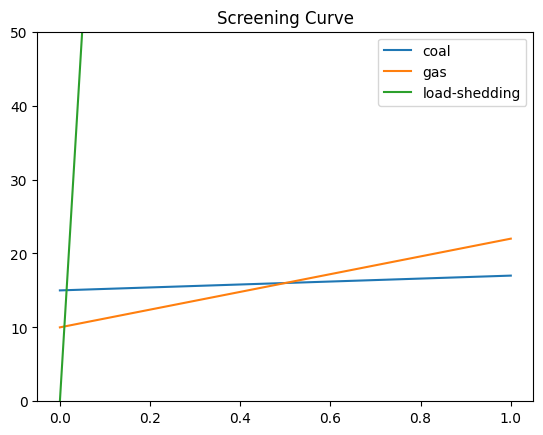

In [8]:
x = np.linspace(0, 1, 101)
df = pd.DataFrame({k: v["c"] + x * v["m"] for k, v in generators.items()}, index=x)
df.plot(ylim=[0, 50], title="Screening Curve");

In [20]:
n = pypsa.Network()

num_snapshots = 1001
n.snapshots = np.linspace(0, 1, num_snapshots)
n.snapshot_weightings = n.snapshot_weightings / num_snapshots

n.add("Bus", name="bus")

n.add("Load", name="load", bus="bus", p_set=1000 - 1000 * n.snapshots.values)

for gen in generators:
    n.add(
        "Generator",
        name=gen,
        bus="bus",
        p_nom_extendable=True,
        marginal_cost=generators[gen]["m"],
        capital_cost=generators[gen]["c"],
    )

<Axes: title={'center': 'Load Duration Curve'}, xlabel='snapshot', ylabel='MW'>

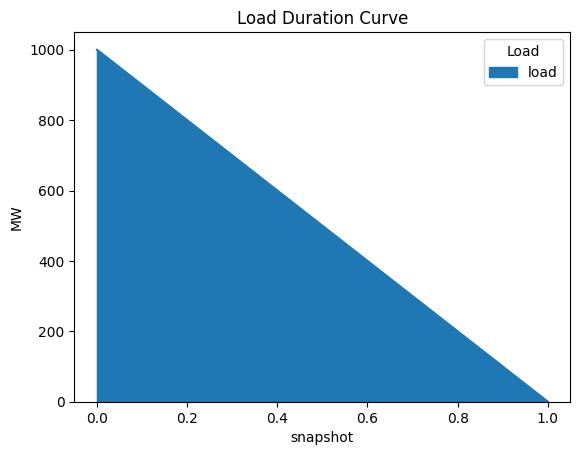

In [21]:
n.loads_t.p_set.plot.area(title="Load Duration Curve", ylabel="MW")

In [22]:
n.optimize()
n.objective

Index(['bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3006 primals, 7010 duals
Objective: 1.47e+04
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-dn1wtpvg has 7010 rows; 3006 cols; 12015 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e-03, 2e+01]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+03]
Presolving model
3000 rows, 3002 cols, 7000 nonzeros  0s
Dependent equations search running on 1000 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
3000 rows, 3002 cols, 7000 nonzeros  0s
Presolve : Reductions: rows 3000(-4010); columns 3002(-4); elements 7000(-5015)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1000(500500) 0s
       1512     1.4706193806e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-dn1wtpvg
Model status        : Optimal
Simplex   iterations: 1512

14706.193806191444

The capacity is set by total electricity required.

**NB:** No load shedding since all prices are below 10 000.

In [23]:
n.generators.p_nom_opt.round(2)

Generator
coal             500.0
gas              490.0
load-shedding     10.0
Name: p_nom_opt, dtype: float64

<Axes: title={'center': 'Price Duration Curve'}, xlabel='snapshot'>

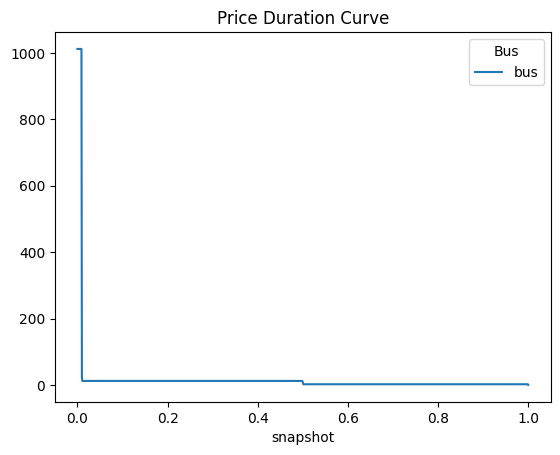

In [24]:
n.buses_t.marginal_price.plot(title="Price Duration Curve")

The prices correspond either to VOLL (1012) for first 0.01 or the marginal costs (12 for 0.49 and 2 for 0.5)

**Except** for (infinitesimally small) points at the screening curve intersections, which correspond to changing the load duration near the intersection, so that capacity changes. This explains 7 = (12+10 - 15) (replacing coal with gas) and 22 = (12+10) (replacing load-shedding with gas). 

Note: What remains unclear is what is causing l = 0... it should be 2.

In [25]:
n.buses_t.marginal_price.round(2).sum(axis=1).value_counts()

2.0       499
12.0      489
1012.0     10
22.0        1
7.0         1
0.0         1
Name: count, dtype: int64

<Axes: title={'center': 'Generation Dispatch'}, xlabel='snapshot'>

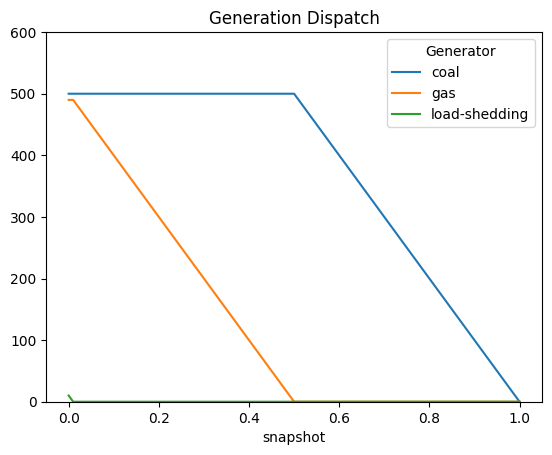

In [27]:
n.generators_t.p.plot(ylim=[0, 600], title="Generation Dispatch")

Demonstrate zero-profit condition.

1. The total cost is given by

In [30]:
weights = n.snapshot_weightings.objective
(
    n.generators.p_nom_opt * n.generators.capital_cost
    + weights @ n.generators_t.p * n.generators.marginal_cost
)

Generator
coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64

2. The total revenue by

In [37]:
weights @ n.generators_t.p.mul(n.buses_t.marginal_price["bus"], axis=0)

Generator
coal             8249.750250
gas              6400.839161
load-shedding      55.604396
Name: objective, dtype: float64

Now, take the capacities from the above long-term equilibrium, then disallow expansion.

Show that the resulting market prices are identical.

This holds in this example, but does **not** necessarily hold and breaks down in some circumstances (for example, when there is a lot of storage and inter-temporal shifting).

In [38]:
n.generators.p_nom_extendable = False
n.generators.p_nom = n.generators.p_nom_opt

In [39]:
n.optimize();

Index(['bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 3003 primals, 7007 duals
Objective: 2.31e+03
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-gk2hmih5 has 7007 rows; 3003 cols; 9009 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [2e-03, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+03]
Presolving model
998 rows, 1996 cols, 1996 nonzeros  0s
Dependent equations search running on 9 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
9 rows, 27 cols, 27 nonzeros  0s
Presolve : Reductions: rows 9(-6998); columns 27(-2976); elements 27(-8982)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.2966633367e+03 Pr: 9(4545) 0s
          9     2.3061938062e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          9     2.29932067

<Axes: title={'center': 'Price Duration Curve'}, xlabel='snapshot'>

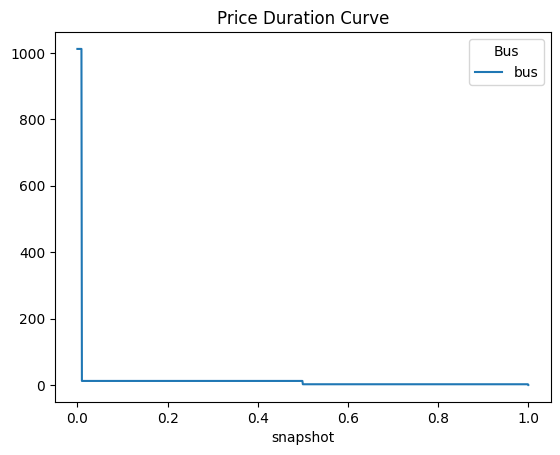

In [40]:
n.buses_t.marginal_price.plot(title="Price Duration Curve")

In [41]:
n.buses_t.marginal_price.sum(axis=1).value_counts()

2.0       500
12.0      490
1012.0     10
0.0         1
Name: count, dtype: int64

Demonstrate zero-profit condition. Differences are due to singular times, see above, not a problem

1. Total costs

In [42]:
(
    n.generators.p_nom * n.generators.capital_cost
    + weights @ n.generators_t.p * n.generators.marginal_cost
)

Generator
coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64

2. Total revenue

In [45]:
weights @ n.generators_t.p.mul(n.buses_t.marginal_price["bus"], axis=0)

Generator
coal             8242.257742
gas              6395.944056
load-shedding      55.604396
Name: objective, dtype: float64